In [ ]:
!pip install nbimporter

In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import torch.nn.init as init
from torch.autograd import Variable
from dataLoader import loadData
from tensorflow import keras

In [2]:
# # Downloading Movielens-1m
# !curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip
# #     http://www.grouplens.org/system/files/ml-1m.zip
# !unzip ml-1m.zip
# !cd ml-1m/

In [3]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [4]:
seed = 47
np.random.seed(seed)

In [5]:
# load data
tr, vr = loadData('./ml-1m/ratings.dat', delimiter='::', seed=seed, transpose=False, valfrac=0.1)

reading data...
data read in 4.520601272583008 seconds
loaded dense data matrix


In [6]:
np.save('./tr_movielens_1m', tr)
np.save('./vr_movielens_1m', vr)

In [7]:
tr

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
vr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
def get_sparsity(mat):
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [10]:
get_sparsity(tr)

4.021525859265269

In [11]:
get_sparsity(vr)

0.44683670296601535

In [12]:
train = tr.copy()

In [13]:
if torch.cuda.is_available() == True:
    device = "cuda"
else:
    device = "cpu"

# Training Denoising Autoencoder

In [70]:
############## Pytorch model doesn't converge - to do - check #################

from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers

def autoEncoder(input_size):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(input_size,), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1', kernel_regularizer=regularizers.l2(0.000001))(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(512, activation='selu', name='LatentSpace', kernel_regularizer=regularizers.l2(0.000001))(enc)
    lat_space = Dropout(0.5, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1', kernel_regularizer=regularizers.l2(0.000001))(lat_space)

    # Output
    output_layer = Dense(input_size, activation='linear', name='UserScorePred', kernel_regularizer=regularizers.l2(0.000001))(dec)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

In [15]:
zero_mask = (train == 0)
positive_feedback = (train > 3)
negative_feedback = ((train < 4) * (1 - zero_mask))

In [16]:
positive_feedback.sum(), negative_feedback.sum()

(517621, 382567)

In [17]:
assert (positive_feedback + negative_feedback != zero_mask).all()
assert (positive_feedback + negative_feedback == 1 - zero_mask).all()

In [18]:
get_sparsity(zero_mask), get_sparsity(positive_feedback), get_sparsity(negative_feedback)

(95.97847414073473, 2.3124349989099473, 1.7090908603553212)

In [19]:
100 - get_sparsity(zero_mask), get_sparsity(positive_feedback), get_sparsity(negative_feedback), get_sparsity(positive_feedback) + get_sparsity(negative_feedback)

(4.021525859265267, 2.3124349989099473, 1.7090908603553212, 4.021525859265268)

In [63]:
# def get_random_batch(mat, batch_size=64):
#     '''
#     returns random rows of size batch_size
#     '''
#     rand_rows = np.random.randint(mat.shape[0], size=batch_size)
# #     print(mat.shape, rand_rows)
# #     print(mat[rand_rows].shape)
#     return mat[rand_rows]

In [85]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, mat, p=0.4, batch_size=64):
        '''
        mat is a binary matrix (e.g. positive feedback, or negative feedback)
        '''
        self.batch_size = batch_size
        self.mat = mat
        self.p = p

    def __len__(self):
        return int(np.floor(self.mat.shape[0] / self.batch_size))
    
    def gen_item(self, index):
        return self.__getitem__(index)
        
    def __getitem__(self, index):
        
        indexes = np.random.randint(self.mat.shape[0], size=self.batch_size)

        mask = (np.random.rand(self.batch_size, self.mat.shape[1]) > self.p)
        
        y = self.mat[indexes]
        X = self.mat[indexes]*mask # corrupting
        
        return X, y

In [86]:
generator_negative = DataGenerator(negative_feedback)

In [87]:
x, y = generator_negative.gen_item(10)

In [88]:
get_sparsity(x), get_sparsity(y)

(1.1379351052347544, 1.9170770372369133)

In [89]:
assert (x*y == x).all()

In [90]:
# P = 0.4
# mask_arr_neg = (np.random.rand(negative_feedback_mask.shape[0], negative_feedback_mask.shape[1]) > P)
# y_neg = negative_feedback_mask
# X_neg = negative_feedback_mask*mask_arr_neg # corrupting 

In [ ]:
# mask_arr_pos = (np.random.rand(positive_feedback_mask.shape[0], positive_feedback_mask.shape[1]) > P)
# y_pos = positive_feedback_mask
# X_pos = positive_feedback_mask*mask_arr_pos # corrupting 

In [ ]:
# corrupted_tr = (mask_arr_neg*(tr>0)).astype(int)

In [ ]:
# get_sparsity(tr), get_sparsity(X_neg), get_sparsity(y_neg), get_sparsity(X_pos), get_sparsity(y_pos), get_sparsity(corrupted_tr)

In [91]:
model_neg = autoEncoder(tr.shape[1])
model_neg.compile(optimizer = Adam(lr=0.0001), loss='mse')

# model_pos = autoEncoder(tr.shape[1])
# model_pos.compile(optimizer = Adam(lr=0.0001), loss='mse')

In [92]:
# model_neg = keras.models.load_model('./model_neg')
# model_pos = keras.models.load_model('./model_pos')

In [93]:
model_neg.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       (None, 3706)              0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 512)               1897984   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               262656    
_________________________________________________________________
Dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 512)               262656    
_________________________________________________________________
UserScorePred (Dense)        (None, 3706)              1901178   
Total params: 4,324,474
Trainable params: 4,324,474
Non-trainable params: 0
_________________________________________________

In [94]:
# predicted_tr = np.load('predicted_tr.npy')
# augmented_train = np.load('augmented_train.npy')

In [95]:
hist_neg = model_neg.fit_generator(
                    generator=generator_negative,
                    epochs=500)

Epoch 1/500
94/94 [==============================] - ETA: 42s - loss: 0.04 - ETA: 23s - loss: 0.05 - ETA: 17s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.05 - ETA: 9s - loss: 0.0522 - ETA: 8s - loss: 0.052 - ETA: 8s - loss: 0.052 - ETA: 7s - loss: 0.053 - ETA: 7s - loss: 0.052 - ETA: 7s - loss: 0.051 - ETA: 6s - loss: 0.051 - ETA: 6s - loss: 0.051 - ETA: 6s - loss: 0.051 - ETA: 6s - loss: 0.050 - ETA: 6s - loss: 0.050 - ETA: 5s - loss: 0.049 - ETA: 5s - loss: 0.049 - ETA: 5s - loss: 0.049 - ETA: 5s - loss: 0.049 - ETA: 5s - loss: 0.048 - ETA: 5s - loss: 0.048 - ETA: 5s - loss: 0.048 - ETA: 5s - loss: 0.048 - ETA: 4s - loss: 0.048 - ETA: 4s - loss: 0.047 - ETA: 4s - loss: 0.047 - ETA: 4s - loss: 0.047 - ETA: 4s - loss: 0.047 - ETA: 4s - loss: 0.047 - ETA: 4s - loss: 0.047 - ETA: 4s - loss: 0.047 - ETA: 4s - loss: 0.046 - ETA: 4s - loss: 0.046 - ETA: 3s - loss: 0.046 - ETA: 3s - loss: 0.046 - ETA: 3s - loss: 0.045 - ETA: 3s - 

94/94 [==============================] - ETA: 5s - loss: 0.029 - ETA: 5s - loss: 0.024 - ETA: 5s - loss: 0.024 - ETA: 5s - loss: 0.025 - ETA: 5s - loss: 0.024 - ETA: 5s - loss: 0.024 - ETA: 5s - loss: 0.023 - ETA: 5s - loss: 0.023 - ETA: 5s - loss: 0.023 - ETA: 5s - loss: 0.023 - ETA: 5s - loss: 0.023 - ETA: 5s - loss: 0.023 - ETA: 5s - loss: 0.023 - ETA: 5s - loss: 0.023 - ETA: 4s - loss: 0.023 - ETA: 4s - loss: 0.023 - ETA: 4s - loss: 0.024 - ETA: 4s - loss: 0.024 - ETA: 4s - loss: 0.024 - ETA: 4s - loss: 0.024 - ETA: 4s - loss: 0.024 - ETA: 4s - loss: 0.024 - ETA: 4s - loss: 0.024 - ETA: 4s - loss: 0.024 - ETA: 4s - loss: 0.024 - ETA: 4s - loss: 0.024 - ETA: 4s - loss: 0.024 - ETA: 4s - loss: 0.023 - ETA: 4s - loss: 0.024 - ETA: 3s - loss: 0.024 - ETA: 3s - loss: 0.024 - ETA: 3s - loss: 0.023 - ETA: 3s - loss: 0.023 - ETA: 3s - loss: 0.023 - ETA: 3s - loss: 0.023 - ETA: 3s - loss: 0.023 - ETA: 3s - loss: 0.023 - ETA: 3s - loss: 0.023 - ETA: 3s - loss: 0.023 - ETA: 3s - loss: 0.023 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.019 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.019 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.019 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.019 - ETA: 5s - loss: 0.019 - ETA: 4s - loss: 0.019 - ETA: 4s - loss: 0.019 - ETA: 4s - loss: 0.019 - ETA: 4s - loss: 0.019 - ETA: 4s - loss: 0.019 - ETA: 4s - loss: 0.019 - ETA: 4s - loss: 0.019 - ETA: 4s - loss: 0.019 - ETA: 4s - loss: 0.018 - ETA: 4s - loss: 0.019 - ETA: 4s - loss: 0.019 - ETA: 4s - loss: 0.019 - ETA: 4s - loss: 0.019 - ETA: 4s - loss: 0.019 - ETA: 3s - loss: 0.019 - ETA: 3s - loss: 0.019 - ETA: 3s - loss: 0.019 - ETA: 3s - loss: 0.019 - ETA: 3s - loss: 0.019 - ETA: 3s - loss: 0.019 - ETA: 3s - loss: 0.019 - ETA: 3s - loss: 0.019 - ETA: 3s - loss: 0.019 - ETA: 3s - loss: 0.019 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 -

94/94 [==============================] - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.015 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.015 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.015 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.015 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.015 - ETA: 4s - loss: 0.015 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 -

94/94 [==============================] - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 -

94/94 [==============================] - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 -

94/94 [==============================] - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 -

94/94 [==============================] - ETA: 6s - loss: 0.017 - ETA: 6s - loss: 0.016 - ETA: 6s - loss: 0.015 - ETA: 6s - loss: 0.015 - ETA: 6s - loss: 0.014 - ETA: 6s - loss: 0.014 - ETA: 6s - loss: 0.014 - ETA: 6s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 -

94/94 [==============================] - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 -

94/94 [==============================] - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 -

94/94 [==============================] - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.015 - ETA: 6s - loss: 0.014 - ETA: 6s - loss: 0.013 - ETA: 6s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 -

94/94 [==============================] - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.016 - ETA: 6s - loss: 0.014 - ETA: 6s - loss: 0.014 - ETA: 6s - loss: 0.015 - ETA: 6s - loss: 0.015 - ETA: 6s - loss: 0.014 - ETA: 6s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 -

94/94 [==============================] - ETA: 7s - loss: 0.013 - ETA: 6s - loss: 0.012 - ETA: 6s - loss: 0.013 - ETA: 6s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.008 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 4s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 6s - loss: 0.013 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 2s - loss: 0.011 -

94/94 [==============================] - ETA: 6s - loss: 0.013 - ETA: 6s - loss: 0.012 - ETA: 6s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.009 - ETA: 5s - loss: 0.009 - ETA: 5s - loss: 0.009 - ETA: 5s - loss: 0.010 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 2s - loss: 0.011 -

94/94 [==============================] - ETA: 4s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.009 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 6s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.009 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 6s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 6s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 7s - loss: 0.013 - ETA: 6s - loss: 0.012 - ETA: 6s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 6s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 6s - loss: 0.008 - ETA: 5s - loss: 0.009 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 6s - loss: 0.009 - ETA: 5s - loss: 0.010 - ETA: 6s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 6s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 6s - loss: 0.012 - ETA: 6s - loss: 0.012 - ETA: 6s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 6s - loss: 0.012 - ETA: 6s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 6s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 4s - loss: 0.011 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.009 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 8s - loss: 0.012 - ETA: 8s - loss: 0.011 - ETA: 7s - loss: 0.011 - ETA: 7s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 2s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 2s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 2s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 6s - loss: 0.012 - ETA: 6s - loss: 0.011 - ETA: 6s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.013 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.009 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.009 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.009 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.009 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.008 - ETA: 5s - loss: 0.009 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.009 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.009 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.010 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 -

94/94 [==============================] - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 -

In [ ]:
# hist_pos = model_pos.fit(x=X_pos, y=y_pos,
#                   epochs=300,
#                   batch_size=128,
#                   shuffle=True,
#                   validation_split=0.0)

In [96]:
import matplotlib.pyplot as plt 

def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    #plt.plot(hist.history['val_loss'])

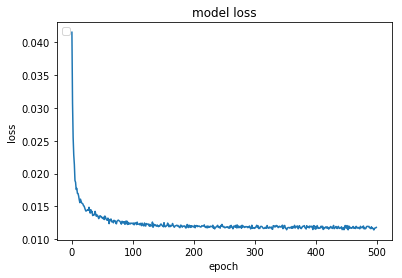

In [97]:
plot_hist(hist_neg)

In [ ]:
# plot_hist(hist_pos)

In [98]:
model_neg.save('./model_neg')
# model_pos.save('./model_pos')

In [99]:
P = 0.4
mask_arr_neg = (np.random.rand(negative_feedback.shape[0], negative_feedback.shape[1]) > P)
y_neg = negative_feedback
X_neg = negative_feedback*mask_arr_neg # corrupting

np.set_printoptions(precision=3)
predicted_neg = model_neg.predict(X_neg)
# predicted_pos = model_pos.predict(X_pos)

In [103]:
(predicted_neg > 0.5).sum(), (y_neg == 1).sum() # predicted vs real

(96206, 382567)

In [102]:
# (predicted_neg>0.5).sum(), (predicted_pos>0.5).sum() # trained on

In [105]:
print((y_neg * (predicted_neg>0.5)).sum()/(predicted_neg>0.5).sum()) # accuracy on actual 
# print((y_pos * (predicted_pos>0.4)).sum()/(predicted_pos>0.4).sum())

0.9706151383489595


In [107]:
# print((y_pos * (predicted_neg>0.4)).sum()/y_pos.sum()) # just to see that it's a low number
# print((y_neg * (predicted_pos>0.4)).sum()/y_neg.sum())

In [108]:
(y_neg * (predicted_neg>0.5)).sum()/((predicted_neg>0.5).sum())

0.9706151383489595

In [ ]:
# (y_pos * (predicted_pos>0.5)).sum()/((predicted_pos>0.5).sum())

In [109]:
((predicted_neg>0.5)  * (X_neg<0.5)).sum() # predicted values which were not in the train matrix

28338

In [ ]:
# ((predicted_pos>0.5)  * (X_pos<0.5)).sum() # predicted values which were not in the train matrix

In [110]:
((y_neg * (((predicted_neg>0.5)  * (X_neg<0.5)))) == 1).sum()/(((predicted_neg>0.5)  * (X_neg<0.5))).sum()

0.9002399604770979

In [ ]:
# ((y_pos * (((predicted_pos>0.5)  * (X_pos<0.5)))) == 1).sum()/(((predicted_pos>0.5)  * (X_pos<0.5))).sum()

In [111]:
to_add_negative = model_neg.predict(y_neg)
# to_add_positive = model_neg.predict(y_pos)

In [112]:
to_add_negative = (to_add_negative>0.5).astype(int)
# to_add_positive = (to_add_positive>0.5).astype(int)

In [114]:
# print((y_pos * to_add_negative).sum()/y_pos.sum()) # That's working
# print((y_neg * to_add_positive).sum()/y_neg.sum())

In [ ]:
# to_add_negative.sum(), to_add_positive.sum()

In [116]:
# (y_neg* (to_add_negative>0.8)).sum()/(((to_add_negative>0.8)).sum()), (y_pos* (to_add_positive>0.8)).sum()/(((to_add_positive>0.8)).sum())

In [120]:
np.unique(to_add_negative * tr)

array([0., 1., 2., 3., 4., 5.])

In [125]:
np.sum(to_add_negative)

199990

In [128]:
print((to_add_negative * (tr==0)).sum()) # new values
print((to_add_negative * (tr==1)).sum()) 
print((to_add_negative * (tr==2)).sum())
print((to_add_negative * (tr==3)).sum())
print((to_add_negative * (tr==4)).sum())
print((to_add_negative * (tr==5)).sum())

14126
26343
49962
103159
5398
1002


In [129]:
to_add_negative = to_add_negative*(tr==0)

In [130]:
np.sum(to_add_negative)

14126

In [ ]:
# # to keep the balance
# threshold_neg = 0.2
# threshold_pos = 0.3 

In [ ]:
# ((to_add_negative > threshold_neg) * (tr==0)).sum(), ((to_add_positive > threshold_pos) * (tr==0)).sum() # new values # new values

In [131]:
p_probs_neg = [(tr == 1).sum()/((tr > 0) & (tr < 4)).sum(), (tr == 2).sum()/(((tr > 0) & (tr < 4))).sum(), (tr == 3).sum()/((tr > 0) & (tr < 4)).sum()]
p_probs_neg

[0.13207882540835983, 0.25313474502505445, 0.6147864295665857]

In [ ]:
# p_probs_pos = [(tr == 4).sum()/((tr > 3) & (tr <= 5)).sum(), (tr == 5).sum()/((tr > 3) & (tr <= 5)).sum()]
# p_probs_pos

In [ ]:
# augmented_train = tr + (to_add_negative > threshold_neg) * (tr == 0) * np.random.choice(np.arange(1, 4), tr.shape, p=p_probs_neg) + (to_add_positive > threshold_pos) * (tr == 0) * np.random.choice(np.arange(4, 6), tr.shape, p=p_probs_pos)

In [132]:
augmented_train = tr + to_add_negative * np.random.choice(np.arange(1, 4), tr.shape, p=p_probs_neg) 

In [133]:
get_sparsity(tr), get_sparsity(augmented_train) # reduced sparsity

(4.021525859265269, 4.084632759477204)

In [134]:
(np.isin(tr, augmented_train)).all()

True

In [135]:
print(5, (5 == tr).sum())
print(4, (4 == tr).sum())
print(3, (3 == tr).sum())
print(2, (2 == tr).sum())
print(1, (1 == tr).sum())
print(0, (0 == tr).sum())

5 203728
4 313893
3 235197
2 96841
1 50529
0 21484052


In [136]:
print(5, (5 == augmented_train).sum())
print(4, (4 == augmented_train).sum())
print(3, (3 == augmented_train).sum())
print(2, (2 == augmented_train).sum())
print(1, (1 == augmented_train).sum())
print(0, (0 == augmented_train).sum())

5 203728
4 313893
3 243911
2 100500
1 52282
0 21469926


In [139]:
((tr == 0) * (augmented_train > 0)).sum() # new values

14126

In [140]:
# np.save('predicted_tr', predicted_tr)
np.save('augmented_train', augmented_train)

In [ ]:
features_length = train.shape[1]
class NetD(torch.nn.Module):
    def __init__(self, feat_size):
        super(NetD, self).__init__()
        self.feat_size = feat_size
#         self.use_cuda = True
#         self.feat_size = feat_size
        # top
#         print(self.feat_size*2)
        self.t1 = torch.nn.Linear(self.feat_size, 1024)
        # bottom
        self.b1 = torch.nn.Linear(self.feat_size, 1024)
        # combined
        self.fc = torch.nn.Linear(2 * 1024, self.feat_size)
    def forward(self, xr, xf):
        # get filt
        
        filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
#         if self.use_cuda: 
        idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = F.tanh(self.fc(x))
        # apply filter, aggregate
        x = filt * x
        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x


class NetG(nn.Module):
    
    def __init__(self, feat_size):

        super(NetG, self).__init__()
        self.feat_size = feat_size
        self.netGen = torch.nn.Sequential( 
                                torch.nn.Linear(nz + self.feat_size, 1024), 
#                                 torch.nn.BatchNorm1d(1024),
                                torch.nn.ReLU(), 
#                                 nn.Dropout(0.5),
#                                 torch.nn.Linear(1024, 1024),
# #                                 torch.nn.BatchNorm1d(1024),
#                                 torch.nn.ReLU(), 
#                                 nn.Dropout(0.6),
                                torch.nn.Linear(1024, features_length), 
                                torch.nn.Sigmoid()
#                                 torch.nn.BatchNorm1d(features_length),
#                                 nn.Dropout(0.7),
#                                 torch.nn.Sigmoid()
                                )

        
    def forward(self, e_mask, x):
        x = self.netGen(x)
        x = x * e_mask
        return x
#         return F.dropout(x, 0.7)
#         return 5 * self.netGen(x)
#         return torch.sigmoid(x) 
#         return x*5 # to get values in range [0,5]

In [ ]:
def get_random_batch(mat, batch_size=64):
    '''
    returns random rows of size batch_size
    '''
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(mat.shape, rand_rows)
#     print(mat[rand_rows].shape)
    return mat[rand_rows]

In [ ]:
# train = torch.autograd.Variable(torch.Tensor(train))
# augmented_train = torch.autograd.Variable(torch.Tensor(augmented_train))

In [ ]:
# del train
# del augmented_train

In [ ]:
# get_sparsity(train.cpu().numpy()), get_sparsity(augmented_train.cpu().numpy())

In [ ]:
# xx = get_random_batch(train)
# xy = get_random_batch(train)

In [ ]:
# d_my(xx, xy)

In [ ]:
# torch.sum(torch.abs(torch.abs(xx != 0).float()*xy - xy), 1)

In [ ]:
# xx > xy

In [ ]:
# # def d_my(x_r, x_g): # custom loss -todo
# #     return torch.sum(torch.abs((x_r != 0).float() * x_g - x_r), 1)/x_r.shape[1]

# def d_my(x_r, x_g): # custom loss -todo
#     return torch.sum(torch.abs(x_g - x_r), 1)/x_r.shape[1]

In [ ]:
def batch_generator(corrupted, original, batch_size=64):
    rand_rows = np.random.randint(corrupted.shape[0], size=batch_size)
    return torch.Tensor(corrupted[rand_rows]).cuda().float(), torch.Tensor(original[rand_rows]).cuda().float(), rand_rows
#     return torch.from_numpy(corrupted[rand_rows]).float(), torch.from_numpy(original[rand_rows]).float()

In [ ]:
# get_sparsity(X_neg), get_sparsity(y_neg)

In [ ]:
# a,b,_ = batch_generator(X_neg, (tr > 0).astype(float))

# get_sparsity(a.cpu().numpy()), get_sparsity(b.cpu().numpy()), a.shape, b.shape

In [ ]:
gen_losses = []
disc_losses = []
def train_GAN(netD, netG, negative, steps_per_epoch = 100, epochs = 100):
    d_iter = 5
    g_iter = 1
    gen_iterations = 0
#     gen_losses = []
#     disc_losses = []
#     train_losses = []
    for epoch in range(epochs):
        for c in range(steps_per_epoch):
            data_iter = 100
            i = 0
            while i < 100:
                ############################
                # (1) Update D network
                ###########################
                for p in netD.parameters(): # reset requires_grad
                    p.requires_grad = True # they are set to False below in netG update
    #             d_iter = d_iter
                j = 0
                while j < d_iter*5:
                    j += 1
                    # load real data
                    i += 1
                    if negative:
                        condition, X, idxs = batch_generator(X_neg, y_neg)
    #                 X, _ = data_iter.next()
    #                 X = X.view(X.size(0), -1)
    #                 X = (X >= 0.5).float()
#                     if cuda: 
                    X = X.cuda()
                    condition = condition.cuda()
    #                 print(condition.shape, X_neg.shape, y_neg.shape)
                    real = Variable(X)

                    # generate fake data
                    noise = torch.randn(batch_size, nz)
#                     if cuda: 
                    noise = noise.cuda()
                    noisev = Variable(noise, volatile = True) # totally freeze netG
                    concated = torch.cat((noisev, condition), 1)
    #                 print(condition.shape, condition.shape, X.shape, noisev.shape, )
                    e_mask = torch.Tensor(tr[idxs]>0).cuda()
                    fake = Variable(netG(e_mask, concated).data)

                    # compute gradient, take step
                    netD.zero_grad()
    #                 concated_real = torch.cat((real, condition), 1)
    #                 print(concated_real)
                    out = netD(real, fake)
                    outputD = torch.mean(out) + lamba * out.norm()
                    stdD = torch.std(out)
                    outputD.backward(mone)
                    optimizerD.step()
#                     print('AAAAAAAAA mse:=WWWWWWWWWWWWWWWWWWWWWW')
            ############################
            # (2) Update G network
            ###########################

    #         g_iter = g_iter
            j = 0
            while j < g_iter*5:
                j += 1
                for p in netD.parameters():
                    p.requires_grad = False # to avoid computation
                netG.zero_grad()
                # load real data

                i += 1

                if negative:
                    condition, X, idxs = batch_generator(X_neg, y_neg)
                    
                X = X.cuda()
                condition = condition.cuda()
                real = Variable(X)

                # update generator
                noise = torch.randn(batch_size, nz)
                noise = noise.cuda()
                noisev = Variable(noise)
                concated_ = torch.cat((noisev, condition), 1)
                e_mask_ = torch.Tensor(tr[idxs]>0).cuda()
 
                fake = netG(e_mask_, concated_)
                out = netD(real, fake)
                outputG = torch.mean(out) + lamba * out.norm()
                stdG = torch.std(out)
                outputG.backward(one)
                optimizerG.step()
                gen_iterations += 1
#             print('AAAAAA')
            eval_loss = F.mse_loss(fake, real, reduction='mean')
#             eval_losses.append(eval_loss)
#             print('mse:', eval_loss)
#             print(outputG.item(), outputD.item())
            gen_losses.append(outputG.item())
            disc_losses.append(outputD.item())
            print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, 100, gen_iterations, outputD.item(), outputG.item()))
    return gen_losses, disc_losses

In [ ]:
# get_sparsity(X_neg), get_sparsity(y_neg)

In [ ]:
# lrD = 5e-4
# lrG = 5e-4
# batch_size = 128
# cuda = True
# epochs = 1000 #change
# seed = 1
# nz = 16
# d_iter = 5
# g_iter = 1
# lamba = 2e-4

lrD = 1e-4
lrG = 1e-4
batch_size = 64
cuda = True
epochs = 1000
device = 5
seed = 1
nz = 20
lamba = 1e-4 
# lamba = 0

In [ ]:
# networks
netD_neg = NetD(negative_feedback_mask.shape[1]).cuda()
netG_neg = NetG(negative_feedback_mask.shape[1]).cuda()
print(netD_neg)
print(netG_neg)
optimizerG = optim.Adam(netG_neg.parameters(), lr=lrG, weight_decay=1e-5)
optimizerD = optim.Adam(netD_neg.parameters(), lr=lrD, weight_decay=1e-5)
one = torch.FloatTensor([1]).cuda()
mone = (-1 * one).cuda()

In [ ]:
netG_neg.load_state_dict(torch.load('./netG_neg-1m'))
netG_neg.eval()

In [ ]:
# netD_neg.train()
# netG_neg.train()
# # gen_losses, disc_losses = train_GAN(netD_neg, netG_neg, negative=True)
# train_GAN(netD_neg, netG_neg, negative=True)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(gen_losses)
plt.show()

In [ ]:
plt.plot(disc_losses)
plt.show()

In [ ]:
# torch.save(netD_neg.state_dict(), './netD_neg-1m')
# torch.save(netG_neg.state_dict(), './netG_neg-1m')

In [ ]:
import gc
gc.collect()

In [ ]:
# to test without train
netD_neg_test = NetD(negative_feedback_mask.shape[1]).cuda()
netG_neg_test = NetG(negative_feedback_mask.shape[1]).cuda()

netD_neg_test.eval()
netG_neg_test.eval()

In [ ]:
condition, X, idxs = batch_generator(X_neg, y_neg, batch_size=256)

X = X.cuda()
condition = condition.cuda()
# real = Variable(X)

noise = torch.randn(256, nz).cuda()
e_mask = torch.Tensor(tr[idxs]>0).cuda()

concated = torch.cat((noise, condition), 1)
fake = netG_neg(e_mask, concated)

In [ ]:
fake_test = netG_neg_test(e_mask, concated)

In [ ]:
(fake >= 0.4).sum(), ((fake >= 0.4) * (condition==0)).sum(), condition.sum(), X.sum(), e_mask.sum()

In [ ]:
fake = (fake > 0.4).float()

In [ ]:
fake_test = (fake_test > 0.4).float()

In [ ]:
(fake * condition).sum()/condition.sum(), (fake * X).sum()/X.sum()

In [ ]:
(fake_test * condition).sum()/condition.sum(), (fake_test * X).sum()/X.sum()

In [ ]:
# accuraccy on zeros (positive feedbacks)
(fake * (1-condition)*X).sum()/(X * (1 - condition)).sum()

In [ ]:
(fake_test * (1-condition)*X).sum()/(X * (1 - condition)).sum()

In [ ]:
# accuraccy on zeros (positive feedbacks)
((1 - fake)*(1-condition)*(torch.from_numpy(positive_feedback_mask[idxs]).float().cuda())).cpu().numpy().sum()/((positive_feedback_mask[idxs]).astype(float)*(1-condition).cpu().numpy()).sum()

In [ ]:
((1 - fake_test)*(1-condition)*(torch.from_numpy(positive_feedback_mask[idxs]).float().cuda())).cpu().numpy().sum()/((positive_feedback_mask[idxs]).astype(float)*(1-condition).cpu().numpy()).sum()

In [ ]:
del fake
del fake_test 
del e_mask

In [ ]:
condition, X, idxs = batch_generator(X_neg, y_neg, batch_size=256)
# predicting on ngetavie feedbacks
condition = torch.from_numpy(X_neg).float().cuda()
X = torch.from_numpy(y_neg).cuda()


noise = torch.randn(condition.shape[0], nz).cuda()
e_mask = torch.Tensor(tr>0).cuda()

concated = torch.cat((noise, condition), 1)
fake = netG_neg(e_mask, concated)

In [ ]:
fake.shape

In [ ]:
fake = (fake > 0.4).float()

In [ ]:
fake = fake.int().cpu().numpy()

In [ ]:
fake = fake.astype(int)

In [ ]:
fake.sum(), negative_feedback_mask.sum(), to_add_negative.sum()

In [ ]:
(fake * negative_feedback_mask).sum()/negative_feedback_mask.sum() #checking negative 

In [ ]:
(fake * to_add_negative).sum()/to_add_negative.sum() #checking negative 

In [ ]:
((1-fake) * positive_feedback_mask).sum()/positive_feedback_mask.sum() #checking positive

In [ ]:
# to_add_negative = to_add_negative.astype(int)

In [ ]:
get_sparsity(to_add_negative), get_sparsity(y_neg)

In [ ]:
(y_neg*to_add_negative).sum()

In [ ]:
# condition, X, idxs = batch_generator(y_neg, to_add_negative, batch_size=256)
# predicting on ngetavie feedbacks
condition = torch.from_numpy(y_neg).float().cuda()
# X = torch.from_numpy(to_add_negative).cuda()


noise = torch.randn(condition.shape[0], nz).cuda()
e_mask = torch.Tensor(to_add_negative).cuda()

concated = torch.cat((noise, condition), 1)
fake = netG_neg(e_mask, concated)

In [ ]:
fake = (fake > 0.5).cpu().numpy()

In [ ]:
fake.sum(), to_add_negative.sum()

In [ ]:
(fake * to_add_negative * (tr==0)).sum()   # checking accuracy with autoencoder generated values

In [ ]:
# checking
print((y_pos * (to_add_negative*fake)).sum()/(to_add_negative*fake).sum()) 
print((y_pos * to_add_negative).sum()/to_add_negative.sum()) 
print((y_pos * fake).sum()/fake.sum()) 

In [ ]:
to_augment_negative = to_add_negative*fake

In [ ]:
print((y_pos * to_augment_negative).sum()/to_augment_negative.sum()) 

In [ ]:
(to_augment_negative *(1-negative_feedback_mask)).sum() #new values

In [ ]:
to_aug = to_augment_negative *(1-negative_feedback_mask)

In [ ]:
to_aug.sum()

In [142]:
import nbimporter 
import matrix_factorization

Importing Jupyter notebook from matrix_factorization.ipynb


In [ ]:
to_add_negative.sum()

In [ ]:
fake.sum()

In [ ]:
(to_aug * (tr == 0)).sum()

In [ ]:
p_probs = [(tr == 1).sum()/((tr > 0) & (tr < 4)).sum(), (tr == 2).sum()/(((tr > 0) & (tr < 4))).sum(), (tr == 3).sum()/((tr > 0) & (tr < 4)).sum()]
p_probs

In [ ]:
augmented_train = tr + to_aug * np.random.choice(np.arange(1, 4), tr.shape, p=p_probs)

In [ ]:
get_sparsity(tr), get_sparsity(augmented_train)

In [143]:
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 60, 80]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

Iteration: 1
Train mse: 1.008322771968567
Test mse: 1.0097737872236334
Iteration: 2
Train mse: 0.9352908086711843
Test mse: 0.9385698023281503
Iteration: 5
Train mse: 0.8643326002534777
Test mse: 0.8713838882692131
Iteration: 10
Train mse: 0.8321892681718779
Test mse: 0.8429431805229121
Iteration: 25
	current iteration: 10
Train mse: 0.8093198899249804
Test mse: 0.8259925315777654
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.7601772428324809
Test mse: 0.7972057401708071
Iteration: 60
	current iteration: 10
Train mse: 0.7215045212306508
Test mse: 0.778059260858409
Iteration: 80
	current iteration: 10
	current iteration: 20
Train mse: 0.633531262561443
Test mse: 0.7509858323451734


In [144]:
MF_SGD_aug = matrix_factorization.ExplicitMF(augmented_train, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 60, 80]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD_aug.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

Iteration: 1
Train mse: 1.0041584117713132
Test mse: 1.0042647306277244
Iteration: 2
Train mse: 0.9310563431939094
Test mse: 0.9345917936674852
Iteration: 5
Train mse: 0.8625311320021543
Test mse: 0.8701743859246871
Iteration: 10
Train mse: 0.8318564735373631
Test mse: 0.8426096169851216
Iteration: 25
	current iteration: 10
Train mse: 0.8097068072368512
Test mse: 0.8260123611186626
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.7563801884005341
Test mse: 0.7942609482091396
Iteration: 60
	current iteration: 10
Train mse: 0.716418396228492
Test mse: 0.7744264187225631
Iteration: 80
	current iteration: 10
	current iteration: 20
Train mse: 0.6314606299911633
Test mse: 0.7485463024141147
